In [26]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
%matplotlib inline

In [27]:
# Import images
car = glob.glob('/Users/TimLapinskas/Desktop/training_data/vehicles/**/*.png')
non_car = glob.glob('/Users/TimLapinskas/Desktop/training_data/non-vehicles/**/*.png')

# Print total images for car and non-car folders
print("Total car images:", len(car))
print("Total non-car images:", len(non_car))

Total car images: 8792
Total non-car images: 8968


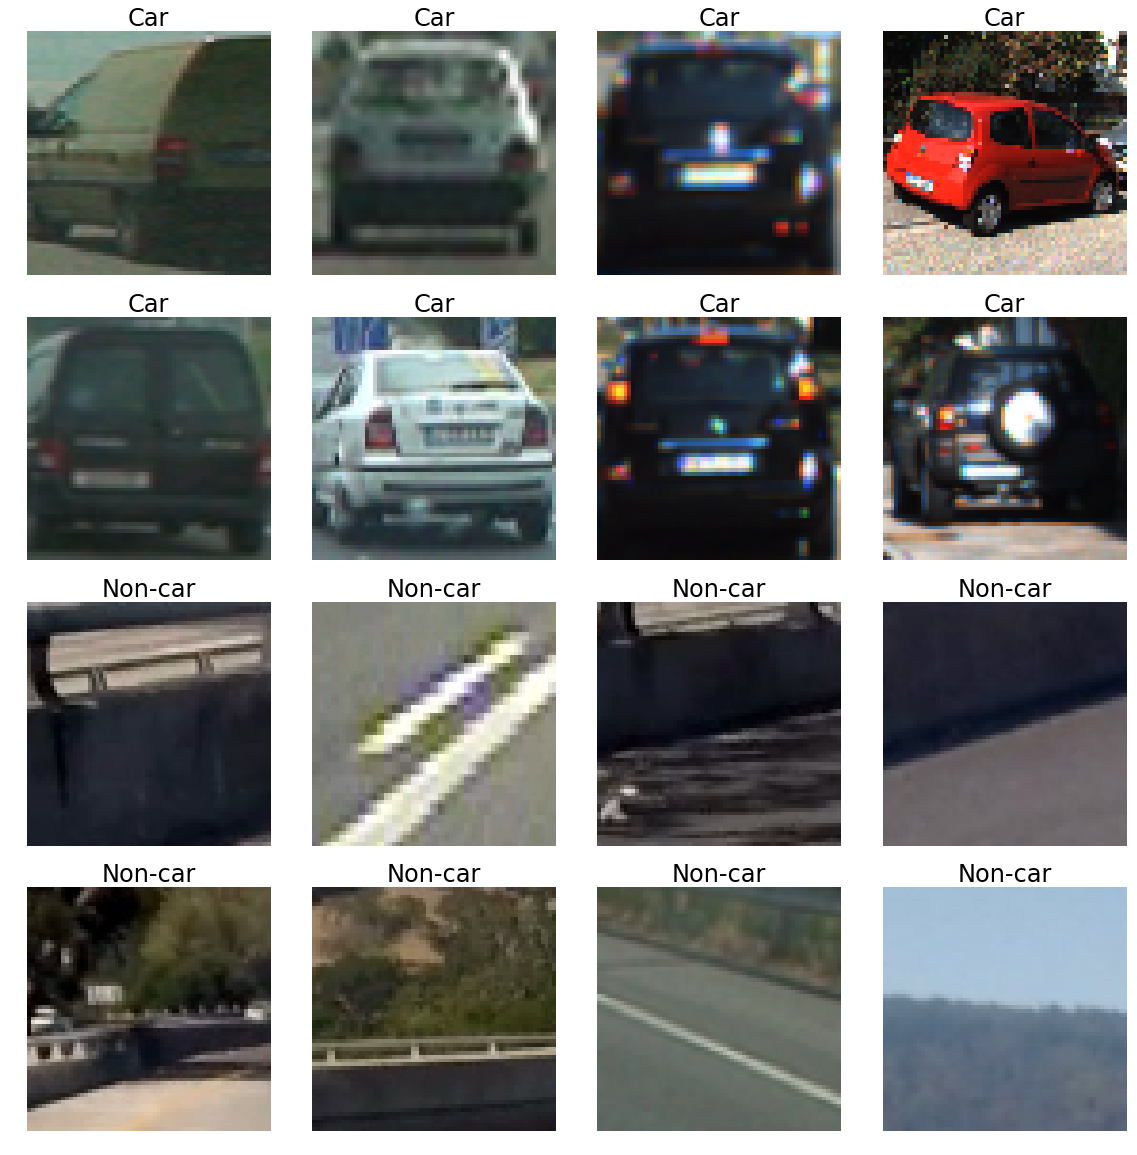

In [28]:
# Visualize some of the car and non car images

# Plot the results of the pipeline
f, axs = plt.subplots(4,4, figsize=(16, 16))
f.tight_layout()
axs = axs.ravel()

for i in np.arange(8):
    image = cv2.imread(car[np.random.randint(0,len(car))])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[i].set_title('Car', fontsize=24)
    axs[i].axis('off')
    axs[i].imshow(image)

for i in np.arange(8, 16):
    image = cv2.imread(non_car[np.random.randint(0, len(non_car))])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[i].set_title('Non-car', fontsize=24)
    axs[i].axis('off')
    axs[i].imshow(image)

In [29]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

/Users/TimLapinskas/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


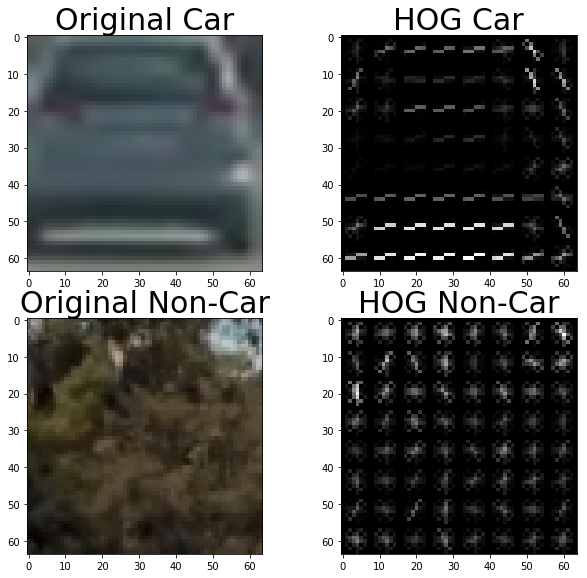

In [30]:
# Visualize HOG

# Car
car_image = mpimg.imread(car[8])
_,car_hog = get_hog_features(car_image[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Non-car
non_car_image = mpimg.imread(non_car[2])
_, non_car_hog = get_hog_features(non_car_image[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

f, axs = plt.subplots(2, 2, figsize=(8, 8))
f.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
axs = axs.ravel()
axs[0].imshow(car_image)
axs[0].set_title('Original Car', fontsize=30)
axs[1].imshow(car_hog, cmap='gray')
axs[1].set_title('HOG Car', fontsize=30)
axs[2].imshow(non_car_image)
axs[2].set_title('Original Non-Car', fontsize=30)
axs[3].imshow(non_car_hog, cmap='gray')
axs[3].set_title('HOG Non-Car', fontsize=30)

In [31]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [32]:
# Feature extraction parameters
colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 6
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(car, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(non_car, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

/Users/TimLapinskas/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


241.36 Seconds to extract HOG features...
Using: 9 orientations 6 pixels per cell and 2 cells per block
Feature vector length: 8748


In [33]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

93.7 Seconds to train SVC...
Test Accuracy of SVC =  0.9704
My SVC predicts:  [ 0.  1.  0.  0.  0.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  0.  1.  0.  0.  0.  0.]
0.04976 Seconds to predict 10 labels with SVC


In [46]:
# # Adapted from lessons.py
# def convert_color(img, conv='RGB2YCrCb'):
#     if conv == 'RGB2YCrCb':
#         return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
#     if conv == 'BGR2YCrCb':
#         return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
#     if conv == 'RGB2LUV':
#         return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
#                         vis=False, feature_vec=True):
#     # Call with two outputs if vis==True
#     if vis == True:
#         features, hog_image = hog(img, orientations=orient, 
#                                   pixels_per_cell=(pix_per_cell, pix_per_cell),
#                                   cells_per_block=(cell_per_block, cell_per_block), 
#                                   transform_sqrt=False, 
#                                   visualise=vis, feature_vector=feature_vec)
#         return features, hog_image
#     # Otherwise call with one output
#     else:      
#         features = hog(img, orientations=orient, 
#                        pixels_per_cell=(pix_per_cell, pix_per_cell),
#                        cells_per_block=(cell_per_block, cell_per_block), 
#                        transform_sqrt=False, 
#                        visualise=vis, feature_vector=feature_vec)
#         return features

# def bin_spatial(img, size=(32, 32)):
#     color1 = cv2.resize(img[:,:,0], size).ravel()
#     color2 = cv2.resize(img[:,:,1], size).ravel()
#     color3 = cv2.resize(img[:,:,2], size).ravel()
#     return np.hstack((color1, color2, color3))
                        
# def color_hist(img, nbins=32):    #bins_range=(0, 256)
#     # Compute the histogram of the color channels separately
#     channel1_hist = np.histogram(img[:,:,0], bins=nbins)
#     channel2_hist = np.histogram(img[:,:,1], bins=nbins)
#     channel3_hist = np.histogram(img[:,:,2], bins=nbins)
#     # Concatenate the histograms into a single feature vector
#     hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
#     # Return the individual histograms, bin_centers and feature vector
#     return hist_features

In [47]:
# # Test find_car function
# test_image = cv2.imread('/Users/TimLapinskas/workspace/github/CarND-Vehicle-Detection/test_images/test1.jpg')
# img = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# # Define a single function that can extract features using hog sub-sampling and make predictions
# def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
#     draw_img = np.copy(img)
#     img = img.astype(np.float32)/255
    
#     img_tosearch = img[ystart:ystop,:,:]
#     ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
#     if scale != 1:
#         imshape = ctrans_tosearch.shape
#         ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
#     ch1 = ctrans_tosearch[:,:,0]
#     ch2 = ctrans_tosearch[:,:,1]
#     ch3 = ctrans_tosearch[:,:,2]

#     # Define blocks and steps as above
#     nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
#     nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
#     nfeat_per_block = orient*cell_per_block**2
    
#     # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
#     window = 64
#     nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
#     cells_per_step = 2  # Instead of overlap, define how many cells to step
#     nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
#     nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
#     # Compute individual channel HOG features for the entire image
#     hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
#     for xb in range(nxsteps):
#         for yb in range(nysteps):
#             ypos = yb*cells_per_step
#             xpos = xb*cells_per_step
#             # Extract HOG for this patch
#             hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

#             xleft = xpos*pix_per_cell
#             ytop = ypos*pix_per_cell

#             # Extract the image patch
#             subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
#             # Get color features
#             spatial_features = bin_spatial(subimg, size=spatial_size)
#             hist_features = color_hist(subimg, nbins=hist_bins)

#             # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
#             #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
#             test_prediction = svc.predict(test_features)
            
#             if test_prediction == 1:
#                 xbox_left = np.int(xleft*scale)
#                 ytop_draw = np.int(ytop*scale)
#                 win_draw = np.int(window*scale)
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
#     return draw_img
    
# ystart = 400
# ystop = 656
# scale = 1.5
    
# out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, None, None)

# plt.imshow(out_img)

In [48]:
# # Test find_car function
# test_image = cv2.imread('/Users/TimLapinskas/workspace/github/CarND-Vehicle-Detection/test_images/test1.jpg')
# test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# # Set parameters
# ystart = 400
# ystop = 656
# scale = 1.5
# colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9
# pix_per_cell = 6
# cell_per_block = 2
# hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

# rectangles = find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

# print(len(rectangles), 'rectangles found in image')

In [49]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    rec = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    # Account for color conversions outside of RGB
    if cspace != 'RBG':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # Select channel for HOG
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else: 
                hog_features = hog_feat1
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
#             test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rec.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return rec

In [50]:
# Test find_car function
test_image = cv2.imread('/Users/TimLapinskas/workspace/github/CarND-Vehicle-Detection/test_images/test1.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# Set parameters
ystart = 400
ystop = 656
scale = 1.5
colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 6
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles = find_cars(test_image, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')

/Users/TimLapinskas/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


error: /Users/jenkins/miniconda/1/x64/conda-bld/conda_1486587097465/work/opencv-3.1.0/modules/imgproc/src/imgwarp.cpp:3230: error: (-215) dsize.area() > 0 || (inv_scale_x > 0 && inv_scale_y > 0) in function resize
